In [1]:
import open3d as o3d
import laspy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyproj

In [2]:
#used to load .las data into a laspy object.
def load_laspy(las_location):
      input_las = laspy.read(las_location)
      
      return input_las

#used to return a list of unique classifications present in the input LAS file.
def get_list_classifications(input_las):
    classifications = list(set(input_las.classification))
    classifications.sort()
    
    return classifications

#Used to return a Python dictionary of laspy objects of the entire dataset as well as individual classifications.
def get_classifications_laspy(input_las):
    #get a unique list of the classifications currently contained in the dataset.
    classifications = get_list_classifications(input_las=input_las)
    #create dictionary with complete data for each province
    d = {"original_dataset": input_las}
    print("The classifications contained in this .las dataset are: ")
    print(classifications)
    print("Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.")
    for classification in classifications:
        print("Saving classification number: " +str(classification))
    
        header = laspy.LasHeader(point_format=input_las.header.point_format, version=input_las.header.version)
        header.scales = np.array([0.001, 0.001, 0.001])

        classified_points = laspy.LasData(header)

        epsg=2960
        crs = pyproj.CRS.from_epsg(epsg)  # example: WGS84
        classified_points.header.add_crs(crs)

        #classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

        classified_points.points = input_las.points[input_las.classification == classification]

        classified_points.header.offsets = input_las.header.offsets

        
        d["classification_{}".format(str(classification))] = classified_points
    
    return d

#Optional function which takes the dictionary of laspy objects and converts every classification
#   into individual .LAS files 
def laspy_classifications_to_las(classifications_laspy):
    for classification_las in classifications_laspy:
        if classification_las == "original_dataset":
            pass
            print("skipped exporting the original dataset.")
        else:
            print("processing {} to a LAS file: ".format(classification_las))
            print(classifications_laspy[classification_las])
            classifications_laspy[classification_las].write("classification_{}.las".format(classification_las.split("_")[1]))
            print("done")

# Convert a .LAS file into a pandas object.
def convert_laspy_pandas(input_las):
    # Convert data into pandas DataFrame
    df = pd.DataFrame({"X":input_las.X,"Y":input_las.Y,"Z":input_las.Z,
      "x":np.array(input_las.x),"y":np.array(input_las.y),"z":np.array(input_las.z),
     'intensity': input_las.intensity,
      'classification': input_las.classification,
      'return_number': np.array(input_las.return_number),
      'number_of_returns':np.array(input_las.number_of_returns),
      'synthetic':np.array(input_las.synthetic),
      'key_point':np.array(input_las.key_point),
      'withheld':np.array(input_las.withheld),
      'overlap':np.array(input_las.overlap),
      'scanner_channel':np.array(input_las.scanner_channel),
      'scan_direction_flag':np.array(input_las.scan_direction_flag),
      'user_data':input_las.user_data,
      'scan_angle':input_las.scan_angle,
      'point_source_id':input_las.point_source_id,
      'gps_time':input_las.gps_time    
      })

    return df

def get_selected_classes(classifications,input_las):
    classes = get_list_classifications(input_las=input_las)
    available_classes = classes
    available_classes.append(1000) #to represent the entire dataset
    class_selections = []
    current_selection = -10

    while current_selection == -10:
        print("Available classifications: " + str(available_classes))
        try:
            current_selection = input("Enter a number from the list of available classifications. To get the full dataset enter 1000 : \n")
            if current_selection.isnumeric() == False:
                print("Invalid Character Input.")
                raise ValueError()
            current_selection = int(current_selection)
            if current_selection not in available_classes:
                print("The classification number you selected: {}, is not an available class item.".format(current_selection))
                cancel = input("Would you like to exit instead? 'Y/N' ").upper() + "Y"
                if cancel[0] == "Y":
                    current_selection = -1000
                    print("Exiting and returning empty classification selection list.")
                    class_selections = []    
                else: 
                    raise ValueError()
            if (current_selection != -1000) & (current_selection != 1000):

                if 1000 in available_classes:
                    available_classes.remove(1000)
                class_selections.append(current_selection)
                print("Class {} added to dataframe.".format(str(current_selection)))
                available_classes.remove(current_selection)
                ask = input("Would you like to add another classification to the dataframe? 'Y/N' ").upper() + "Y"

                #If user prompts to add another classification, reset variable and start again.
                if ask[0] == "Y":
                    current_selection = -10
                #If user prompts to stop, exit loop and create pandas dataframe.
                else:
                    print("Classifications have been selected.")
                    class_selections.sort()

            elif current_selection == 1000:
                print("The entire dataset has been selected")
                class_selections = get_list_classifications(input_las=input_las)
                print("All classes have been added to the dataframe.")
                class_selections.sort()

        except ValueError:
            print("Please select an input from the available classification list. \n")
            current_selection = -10

    
    return class_selections

def create_combined_classifications_dataframe(class_selections,df):
    if len(class_selections) > 0:
        #initialize the dataframe with the first set of classifications
        combined_df = df.loc[df["classification"] == class_selections[0]]
        #iterate and append remaining classifications 
        for selection in class_selections[1:]:
            combined_df=pd.concat([combined_df, df.loc[df["classification"] == selection]])
    else:
        combined_df = pd.DataFrame()

    return combined_df

def create_laspy_from_dataframe(input_las,combined_df):
    classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]

    return classified_points

def get_numpy_points_from_laspy_scaled(classified_points):
    point_records = classified_points.points.copy()
    # getting scaling and offset parameters
    las_scaleX = classified_points.header.scale[0]
    las_offsetX = classified_points.header.offset[0]
    las_scaleY = classified_points.header.scale[1]
    las_offsetY = classified_points.header.offset[1]
    las_scaleZ = classified_points.header.scale[2]
    las_offsetZ = classified_points.header.offset[2]
    # calculating coordinates
    p_X = np.array((point_records.X * las_scaleX) + las_offsetX) 
    p_Y = np.array((point_records.Y * las_scaleY) + las_offsetY)
    p_Z = np.array((point_records.Z * las_scaleZ) + las_offsetZ)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy


def get_numpy_points_from_laspy_unscaled(classified_points):
    point_records = classified_points.points.copy()
    # calculating coordinates
    p_X = np.array(point_records.X)
    p_Y = np.array(point_records.Y)
    p_Z = np.array(point_records.Z)

    classified_points_numpy = np.array(list(zip(p_X,p_Y,p_Z)))

    return classified_points_numpy

def get_numpy_points_from_pandas_unscaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["X"]),
                                    np.array(combined_df["Y"]),
                                    np.array(combined_df["Z"]))))

    return classified_points_numpy

def get_numpy_points_from_pandas_scaled(combined_df):

    classified_points_numpy = np.array(list(zip(np.array(combined_df["x"]),
                                    np.array(combined_df["y"]),
                                    np.array(combined_df["z"]))))

    return classified_points_numpy

#input numpy array to visualize using open3d
def visualize_las(classified_points,df= pd.DataFrame()):
        
    dataset = classified_points
    geom = o3d.geometry.PointCloud()
    geom.points = o3d.utility.Vector3dVector(dataset)
    #geom.colors = o3d.utility.Vector3dVector(x)
    #print(df)

    if df.empty is False:
        print("entered df")
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=df.X[0], origin=[df.X.mean(), df.Y.mean(), df.Z.mean()])
        #coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[df.X.mean(),df.Y.mean(),df.Z.mean()])
        coord = o3d.geometry.TriangleMesh().create_coordinate_frame(size=0.5, origin=[0,0,0])
        o3d.visualization.draw_geometries([coord,geom])
        #o3d.visualization.draw_geometries([geom])

    else:
        o3d.visualization.draw_geometries([geom])
        print("did not enter df")


def create_laspy_from_dataframe(input_las,combined_df):
    #classified_points = laspy.create(point_format=input_las.header.point_format, file_version=input_las.header.version)

    #Create a header for the new .Las file
    # Header class properties (https://laspy.readthedocs.io/en/latest/api/laspy.header.html)
    header = laspy.LasHeader(point_format=input_las.header.point_format, version=input_las.header.version)
    header.scales = np.array([0.001, 0.001, 0.001])

    crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
    
    classified_points = laspy.LasData(header)

    classified_points.X = combined_df["X"]
    classified_points.Y = combined_df["Y"]
    classified_points.Z = combined_df["Z"]
    classified_points.intensity = combined_df["intensity"]
    classified_points.classification = combined_df["classification"]


    #Apply the add_crs function to add a crs to our header.
    classified_points.header.add_crs(crs)
    #Select the offset from the input las data.
    classified_points.header.offsets = input_las.header.offsets
    #header.y_offset=0

    return classified_points
    

def multiple_classifications_to_las(classified_points,class_selections):
    ##write to a .las file
    class_selections.sort()
    sorted_classes_str = "_".join(map(str,class_selections))
    las_file_name = "classifications_" + sorted_classes_str +".las"
    classified_points.write(las_file_name)
    print("Created file: " + sorted_classes_str)




In [3]:
input_las = load_laspy('Tile65_Original_Clean_Macro.las')



#Obtain the classifications available for the dataset
classifications = get_list_classifications(input_las=input_las)

#Create a python dictionary containing the original dataset
# as well as classifications in individual laspy objects.
classifications_laspy =  get_classifications_laspy(input_las=input_las)


df = convert_laspy_pandas(input_las=input_las)


#To get a pandas dataframe with specified classification values
#Inform user which class values are present 
#Proceed by prompting user input to select classes to group into a final dataframe.
class_selections = get_selected_classes(classifications = classifications,input_las=input_las)

# Form a pandas dataframe from user-selected classifications
combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)

##Create laspy points from the pandas dataframe of selected user classifications
classified_points = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

#create a las object for each classification set of points
laspy_classifications_to_las(classifications_laspy=classifications_laspy)
#export every single classification as its own .LAS data
multiple_classifications_to_las(classified_points=classified_points,class_selections=class_selections)



The classifications contained in this .las dataset are: 
[0, 7, 9, 18, 40, 41, 42, 80]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 0
Saving classification number: 7
Saving classification number: 9
Saving classification number: 18
Saving classification number: 40
Saving classification number: 41
Saving classification number: 42
Saving classification number: 80
Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
Class 42 added to dataframe.
Classifications have been selected.
skipped exporting the original dataset.
processing classification_0 to a LAS file: 
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 433239 points, 1 vlrs)>
done
processing classification_7 to a LAS file: 
<LasData(1.4, point fmt: <PointFormat(6, 0 bytes of extra dims)>, 23062 points, 1 vlrs)>
done
processing classification_9 to a LAS file: 
<LasData(1.4, point fmt: <PointFormat(6, 0 byt

In [40]:
input_las = load_laspy('Tile65_Original_Clean_Macro.las')
df = convert_laspy_pandas(input_las=input_las)


crs = pyproj.CRS.from_epsg(2960)  # example: WGS84
input_las.header.add_crs(crs=crs)

x = input_las.x
y = input_las.y
z = input_las.z

xmin, ymin, xmax, ymax = input_las.header.min[0], input_las.header.min[1], input_las.header.max[0], input_las.header.max[1]
cell_size = 0.1  # Specify the cell size
xx, yy = np.meshgrid(np.arange(xmin, xmax, cell_size), np.arange(ymin, ymax, cell_size))


In [41]:
df

,X,Y,Z,x,y,z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
0,290988240,-186802461,-278,290988.240,4813197.539,-0.278,2474,9,1,1,0,0,0,0,0,1,1,-1685,2610,135243.776060
1,290987469,-186802282,-237,290987.469,4813197.718,-0.237,1869,9,1,1,0,0,0,0,0,1,1,-1667,2610,135243.776074
2,290987360,-186802266,-267,290987.360,4813197.734,-0.267,4226,9,1,1,0,0,0,0,0,1,1,-1664,2610,135243.776076
3,290987251,-186802246,-286,290987.251,4813197.754,-0.286,16268,9,1,1,0,0,0,0,0,1,1,-1662,2610,135243.776078
4,290987142,-186802229,-314,290987.142,4813197.771,-0.314,2284,9,1,1,0,0,0,0,0,1,1,-1659,2610,135243.776080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475674,291014354,-186957702,-13723,291014.354,4813042.298,-13.723,1116,0,4,4,0,0,0,0,0,0,4,2718,2812,135839.348992
1475675,291017691,-186957217,-15297,291017.691,4813042.783,-15.297,872,0,5,5,0,0,0,0,0,0,4,2658,2812,135839.349064
1475676,291013483,-186958110,-13518,291013.483,4813041.890,-13.518,799,0,4,4,0,0,0,0,0,0,4,2730,2812,135839.358309
1475677,291018905,-186957521,-15309,291018.905,4813042.479,-15.309,870,0,3,3,0,0,0,0,0,0,4,2634,2812,135839.358424


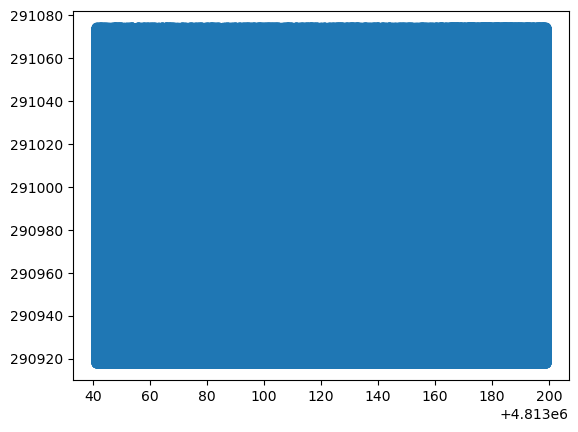

In [39]:
plt.scatter(y,x)

 ...]

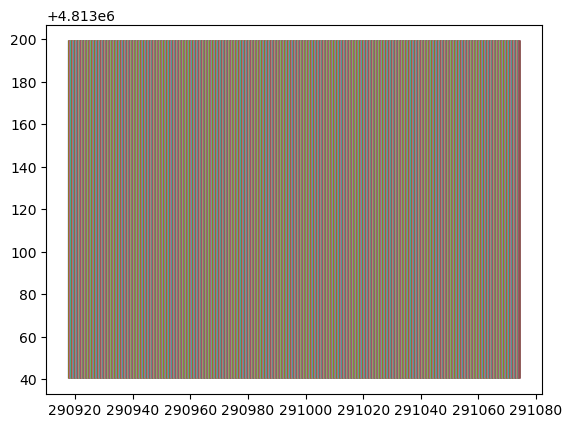

In [32]:
plt.plot(xx,yy)

In [21]:
from scipy.interpolate import griddata

# Interpolate the elevation values for each cell in the grid
grid_z = griddata((x, y), z, (xx, yy), method='linear')


In [23]:
import rasterio

# Save the DEM as a GeoTIFF file
with rasterio.open("dem.tif", "w", driver="GTiff", width=grid_z.shape[1], height=grid_z.shape[0], count=1, dtype=grid_z.dtype, crs=pyproj.CRS.from_epsg(2960)) as dst:
    dst.write(grid_z, 1)


In [28]:
ls

Tile65_Original_Clean_Macro.las   classification_7.las
Tile65_Original_Clean_Macro.lasx  classification_80.las
Tile65_denoisedZ.ply              classification_9.las
Tile65_denoisedZ_40_41_42.ply     classifications_42.las
Tile65_denoisedZ_41_42.ply        dem.tif
acenet/                           esri_lidar.ipynb
bio-env.txt                       esri_lidar_converted/
classification_0.las              laspy_arcpro.ipynb
classification_18.las             laspy_open3d.ipynb
classification_40.las             lidar_convert.ipynb
classification_41.las             lidar_fitting.ipynb
classification_42.las


In [27]:
 from PIL import Image
im = Image.open('dem.tif')
im.show()

UnidentifiedImageError: cannot identify image file 'dem.tif'

In [25]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the TIF file using mpimg.imread()
img = mpimg.imread('/Users/juancreyes/Documents/GitHub/lidar_processing/python38/dem.tif')

# Display the image using plt.imshow()
plt.imshow(img)

# Show the plot
plt.show()


UnidentifiedImageError: cannot identify image file '/Users/juancreyes/Documents/GitHub/lidar_processing/python38/dem.tif'

In [5]:
import numpy as np
def func(x, y):
    return x*(1-x)*np.cos(4*np.pi*x) * np.sin(4*np.pi*y**2)**2


In [6]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:200j]


In [8]:
rng = np.random.default_rng()
points = rng.random((1000, 2))
values = func(points[:,0], points[:,1])

In [10]:
from scipy.interpolate import griddata
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
grid_z1 = griddata(points, values, (grid_x, grid_y), method='linear')
grid_z2 = griddata(points, values, (grid_x, grid_y), method='cubic')

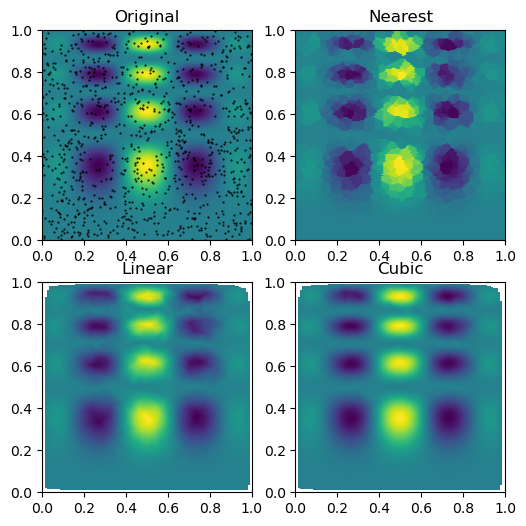

In [11]:
import matplotlib.pyplot as plt
plt.subplot(221)
plt.imshow(func(grid_x, grid_y).T, extent=(0,1,0,1), origin='lower')
plt.plot(points[:,0], points[:,1], 'k.', ms=1)
plt.title('Original')
plt.subplot(222)
plt.imshow(grid_z0.T, extent=(0,1,0,1), origin='lower')
plt.title('Nearest')
plt.subplot(223)
plt.imshow(grid_z1.T, extent=(0,1,0,1), origin='lower')
plt.title('Linear')
plt.subplot(224)
plt.imshow(grid_z2.T, extent=(0,1,0,1), origin='lower')
plt.title('Cubic')
plt.gcf().set_size_inches(6, 6)
plt.show()

In [21]:
# Read .las file with the load_laspy() function. Note we cannot handle .laz data.
input_las = load_laspy('Tile65_Original_Clean_Macro.las')
#input_las = load_laspy("200-145324069_ground.las")
#Obtain the classifications available for the dataset
classifications = get_list_classifications(input_las=input_las)
#Create a python dictionary containing the original dataset
# as well as classifications in individual laspy objects.
classifications_laspy =  get_classifications_laspy(input_las=input_las)

#If we choose to export each classification into individual .las files.
#laspy_classifications_to_las(classifications_laspy=classifications_laspy)

#Create a pandas dataframe containing the entire pointcloud.
df = convert_laspy_pandas(input_las=input_las)
#Create a pandas dataframe for ground class "2"
if len(df[df["classification"] == 2]) > 0:
    ground = df[df["classification"] == 2]
#Create a pandas dataframe for low veg class "3"
if len(df[df["classification"] == 3]) > 0:
    low_veg = df[df["classification"] == 3]
#Create a pandas dataframe for med veg class "4"
if len(df[df["classification"] == 4]) > 0:
    med_veg = df[df["classification"] == 4]
#Create a pandas dataframe for high veg class "5"
if len(df[df["classification"] == 5]) > 0:
    high_veg = df[df["classification"] == 5]
#Create a pandas dataframe for high veg class "7"
if len(df[df["classification"] == 7]) > 0:
    low_noise = df[df["classification"] == 7]
#Create a pandas dataframe for high veg class "9"
if len(df[df["classification"] == 9]) > 0:
    topo_water_surface = df[df["classification"] == 9]
#Create a pandas dataframe for high noise "18"
if len(df[df["classification"] == 18]) > 0:
    high_noise = df[df["classification"] == 18]
#Create a pandas dataframe for classified bathymetry "40"
if len(df[df["classification"] == 40]) > 0:
    bathymetry = df[df["classification"] == 40]
#Create a pandas dataframe for classified bathymetric water surface "41"
if len(df[df["classification"] == 41]) > 0:
    bathymetric_water = df[df["classification"] == 41]
#Create a pandas dataframe for classified derived water surface "42"
if len(df[df["classification"] == 42]) > 0:
    derived_water_surface = df[df["classification"] == 42]
#Create a pandas dataframe for bathymetric vegetation "80"
if len(df[df["classification"] == 80]) > 0:
    bathy_veg = df[df["classification"] == 80]
#To get a pandas dataframe with specified classification values
#Inform user which class values are present 
#Proceed by prompting user input to select classes to group into a final dataframe.
class_selections = get_selected_classes(classifications = classifications,input_las=input_las)
# Form a pandas dataframe from user-selected classifications
combined_df = create_combined_classifications_dataframe(class_selections=class_selections,df=df)

##Create laspy points from the pandas dataframe of selected user classifications
classified_points = create_laspy_from_dataframe(input_las=input_las,combined_df=combined_df)

###                                 ###
###DATA CONVERSION FOR VISUALIZATION###
###             #                   ###
# Convert classified_points (laspy data) or combined_df (pandas data) to numpy data for visualization
#   with the pptk library. 
#Convert from laspy to numpy scaled
classified_points_numpy_scaled_laspy = get_numpy_points_from_laspy_scaled(classified_points=classified_points)
#Convert from laspy to numpy unscaled
classified_points_numpy_unscaled_laspy = get_numpy_points_from_laspy_unscaled(classified_points=classified_points)
#Convert from pandas to numpy scaled
classified_points_numpy_scaled_pandas = get_numpy_points_from_pandas_scaled(combined_df=combined_df)
#Convert from pandas to numpy unscaled
classified_points_numpy_unscaled_pandas = get_numpy_points_from_pandas_unscaled(combined_df=combined_df)



########Individual Classifications#######
low_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = low_noise)
topo_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = topo_water_surface)
high_noise_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = high_noise)
bathymetry_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetry)
bathymetric_water_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = bathymetric_water)
derived_water_surface_unscaled = get_numpy_points_from_pandas_unscaled(combined_df = derived_water_surface)
bathy_veg_unscaled = get_numpy_points_from_pandas_unscaled(combined_df =bathy_veg)

The classifications contained in this .las dataset are: 
[0, 7, 9, 18, 40, 41, 42, 80]
Creating a python dictionary containing the entire dataset and individual classifications as separate laspy objects.
Saving classification number: 0
Saving classification number: 7
Saving classification number: 9
Saving classification number: 18
Saving classification number: 40
Saving classification number: 41
Saving classification number: 42
Saving classification number: 80
Available classifications: [0, 7, 9, 18, 40, 41, 42, 80, 1000]
The entire dataset has been selected
All classes have been added to the dataframe.


In [5]:
combined_df["X_mean_shift"] = combined_df.X - combined_df.X.mean()
combined_df["Y_mean_shift"] = combined_df.Y - combined_df.Y.mean()
combined_df["Z_mean_shift"] = combined_df.Z - combined_df.Z.mean()

In [12]:
combined_df

,X,Y,Z,intensity,classification,return_number,number_of_returns,synthetic,key_point,withheld,overlap,scanner_channel,scan_direction_flag,user_data,scan_angle,point_source_id,gps_time
2567,290999485,-186802015,-6063,19192,40,1,1,0,0,0,0,0,1,2,-1890,2610,135243.728149
2568,290998268,-186801807,-6001,20705,40,1,1,0,0,0,0,0,1,2,-1864,2610,135243.728178
2570,290997022,-186801595,-5993,19004,40,2,3,0,0,0,0,0,1,2,-1836,2610,135243.728207
2572,290995781,-186801367,-5945,21545,40,2,6,0,0,0,0,0,1,2,-1809,2610,135243.728237
2577,290994546,-186801135,-5915,19130,40,2,2,0,0,0,0,0,1,2,-1781,2610,135243.728266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1475458,291022825,-186959005,-251,65530,42,0,2,0,0,0,0,0,0,4,2610,2812,135839.302463
1475461,291024199,-186959004,-242,65530,42,0,3,0,0,0,0,0,0,4,2585,2812,135839.302492
1475465,291025607,-186959020,-226,65530,42,0,3,0,0,0,0,0,0,4,2560,2812,135839.302521
1475469,291027003,-186959050,-212,65530,42,0,2,0,0,0,0,0,0,4,2534,2812,135839.302550


In [11]:
multiple_classifications_to_las(classified_points=classified_points,class_selections=class_selections)

Created file: 40_41_42
